Toxic Comment Classification

Import modules

In [105]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist, bigrams, word_tokenize
from nltk.corpus import CategorizedPlaintextCorpusReader
from nltk.probability import ConditionalFreqDist
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter, defaultdict

In [87]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hugom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hugom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hugom\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\hugom\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

1. Data Download and Loading

1.1 Loading Data with pandas

In [4]:
def load_data(train_path, test_path):
    df_train = pd.read_csv(train_path)
    df_test  = pd.read_csv(test_path)

    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    df_train['non_toxic'] = (df_train[label_cols].sum(axis=1) == 0).astype(int)

    return df_train, df_test

# Example usage
df_train, df_test = load_data(
    'Dataset/train.csv',
    'Dataset/test.csv'
)

1.2 Initial Inspection

Display dimensions:

In [5]:
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (159571, 9)
Test shape: (153164, 2)


Show first rows:

In [6]:
display(df_train.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


Null values by column in train:

In [7]:
print(df_train.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
non_toxic        0
dtype: int64


Label distribution in train:

In [8]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
print(df_train[label_cols].sum().sort_values(ascending=False))

non_toxic        143346
toxic             15294
obscene            8449
insult             7877
severe_toxic       1595
identity_hate      1405
threat              478
dtype: int64


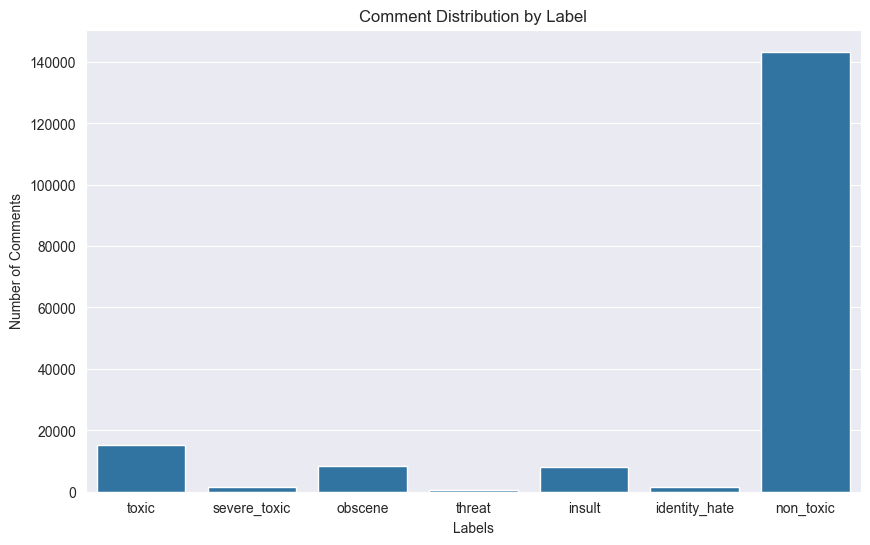

In [9]:
plt.figure(figsize=(10,6))
sns.barplot(x=df_train[label_cols].sum().index, y=df_train[label_cols].sum().values)
plt.title('Label distribution')
plt.title('Comment Distribution by Label')
plt.ylabel('Number of Comments')
plt.xlabel('Labels')
plt.show()

2. First Analysis

2.1 Missing Values and Null Checks

In [10]:
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
non_toxic        0
dtype: int64

2.2 Class Distribution

The dataset has six target columns: toxic, severe_toxic, obscene, threat, insult, identity_hate.

Display the count and proportion of each class:

In [11]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
class_counts = df_train[label_cols].sum().sort_values(ascending=False)
class_props = class_counts / len(df_train)
print(pd.concat([class_counts, class_props], axis=1, keys=['count','proportion']))

                count  proportion
non_toxic      143346    0.898321
toxic           15294    0.095844
obscene          8449    0.052948
insult           7877    0.049364
severe_toxic     1595    0.009996
identity_hate    1405    0.008805
threat            478    0.002996


2.3 Comment Length Analysis

Compute length of each comment (in characters and words):

In [12]:
df_train['char_count'] = df_train['comment_text'].apply(len)
df_train['word_count'] = df_train['comment_text'].apply(lambda x: len(x.split()))
display(df_train[['char_count','word_count']].describe())

,char_count,word_count
count,159571.000000,159571.000000
mean,396.593961,67.273527
std,594.387869,99.230702
min,6.000000,1.000000
25%,97.000000,17.000000
50%,207.000000,36.000000
75%,438.000000,75.000000
max,5000.000000,1411.000000


Plot histograms of comment lengths:

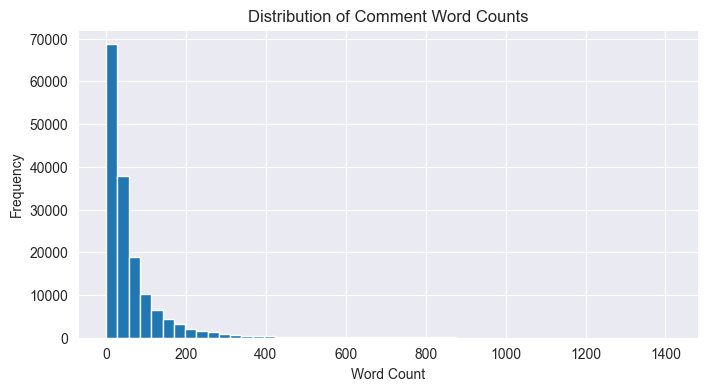

In [13]:
plt.figure(figsize=(8,4))
df_train['word_count'].hist(bins=50)
plt.title('Distribution of Comment Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

2.4 Sample Comments by Category

Show example comments for each label where the label is 1:

In [14]:
for col in label_cols:
    print(f"\nExamples of {col} comments:")
    examples = df_train[df_train[col]==1]['comment_text'].sample(2, random_state=42).tolist()
    for ex in examples:
        print("- ", ex)


Examples of toxic comments:
-  Hi! 

I wanna rape you!
-  Terrorize 
I will terrorise you for as long as you live - you are an arrogant, disgusting and rude excuse for a human being & you are going to die soon so I suggest you stop threatening people you bastard.

Examples of severe_toxic comments:
-  "

 WHAT  IN THE FUCK ARE YOU REFERRING TOO 

I HAVE NO IDEA WHAT THE PISS YOU'RE REFERRING TOO, OR WHY YOU BOTHERED TO WRITE ME.  LISTEN I'VE ADDED PLENTY TO THESE PAGE INCLUDING A ""SMASHING"" ARTICLE ON SMASHED GLADYS...BUT THAT REALLY ISNT ANY OF YOU BUSSINESS NOW IS IT.  IF SOMEBODY HAS A PROBLEM WITH ANYTHING THAT I WROTE THEM I ASSUME THEY CAN CONTACT ME THROUGH REGULAR MEANS WITHOUT YOU HAVING TO ""WIPE THEIR ASS"" FOR THEM.  IF I CAPITALIZE IT IS NOT MEANT NECCISARYLY AS AN INSULT, AND MOST PEOPLE I WRITE UNDERSTAND THAT.  IN THIS CASE IT IS BECAUSE MY CAPS BUTTON ISNT WORKING FOR SOME REASON.  SO HERES AN IDEA FOR YOU...DONT SHOVE YOUR NOSE IN MY BUSSINESS, I AM CLOSE FREINDS W

3. Create corpus

In [15]:
# Crear el directorio principal para almacenar el corpus
corpus_dir = 'corpus_by_label'
os.makedirs(corpus_dir, exist_ok=True)

# Guardar los comentarios en carpetas y archivos separados por etiqueta
for label in label_cols:
    comments = df_train[df_train[label] == 1]['comment_text'].dropna()

    # Crear una carpeta con el nombre de la etiqueta
    label_dir = os.path.join(corpus_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    # Ruta del archivo dentro de la carpeta creada
    file_path = os.path.join(label_dir, f"{label}.txt")

    # Guardar todos los comentarios de la etiqueta en el archivo dentro de su carpeta
    with open(file_path, 'w', encoding='utf-8') as f:
        for comment in comments:
            f.write(comment.replace('\n', ' ') + '\n')

print(f"Corpus successfully loaded in: {corpus_dir}")

Corpus successfully loaded in: corpus_by_label


In [16]:
# Load corpus
corpus = CategorizedPlaintextCorpusReader(
    corpus_dir,
    r'.*\.txt',
    cat_pattern=r"([^/.]+)/.*"
)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hugom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
print("File IDs:", corpus.fileids())
print("Categories:", corpus.categories())

File IDs: ['identity_hate/identity_hate.txt', 'insult/insult.txt', 'non_toxic/non_toxic.txt', 'obscene/obscene.txt', 'severe_toxic/severe_toxic.txt', 'threat/threat.txt', 'toxic/toxic.txt']
Categories: ['identity_hate', 'insult', 'non_toxic', 'obscene', 'severe_toxic', 'threat', 'toxic']


In [18]:
print("Primeras 10 palabras de 'toxic':")
print(corpus.words(categories='toxic')[:10])

Primeras 10 palabras de 'toxic':
['COCKSUCKER', 'BEFORE', 'YOU', 'PISS', 'AROUND', 'ON', 'MY', 'WORK', 'Hey', '...']


In [19]:
stop_words = set(stopwords.words('english'))
words = [word.lower() for word in corpus.words()]
corpus_norm = [word for word in words if word.isalpha() and word not in stop_words]

def normalizer(category):
    words = [word.lower() for word in corpus.words(categories=category)]
    return [word for word in words if word.isalpha() and word not in stop_words]

categories_norm = {
    "identity_hate": normalizer("identity_hate"),
    "insult": normalizer("insult"),
    "obscene": normalizer("obscene"),
    "severe_toxic": normalizer("severe_toxic"),
    "threat": normalizer("threat"),
    "toxic": normalizer("toxic"),
    "non_toxic": normalizer("non_toxic")
}


4. Corpus Analysis

Number of words and vocabulary

In [25]:
print(f"Word tokens in the corpus: {len(corpus.words())}")
print(f"Wordforms in the corpus: {len(set(corpus.words()))}\n")

for category in corpus.categories():
    print(f"{category}:")
    print(f"Word tokens in {category}: {len(corpus.words(categories=category))}")
    print(f"Wordforms in {category}: {len(set(corpus.words(categories=category)))}\n")

Word tokens in the corpus: 14315304
Wordforms in the corpus: 240640

identity_hate:
Word tokens in identity_hate: 88394
Wordforms in identity_hate: 9768

insult:
Word tokens in insult: 469413
Wordforms in insult: 27175

non_toxic:
Word tokens in non_toxic: 12090930
Wordforms in non_toxic: 226814

obscene:
Word tokens in obscene: 519918
Wordforms in obscene: 29053

severe_toxic:
Word tokens in severe_toxic: 149959
Wordforms in severe_toxic: 8292

threat:
Word tokens in threat: 32656
Wordforms in threat: 3926

toxic:
Word tokens in toxic: 964034
Wordforms in toxic: 44743



Lexical diversity

In [31]:
def lexical_diversity(words):
    return len(set(words)) / len(words)

print(f"Total corpus lexical diversity: {round(100 * lexical_diversity(corpus.words()), 2)}%\n")

for category in corpus.categories():
    print(f"{category} lexical diversity: {round(100 * lexical_diversity(corpus.words(categories=category)), 2)}%\n")

Total corpus lexical diversity: 1.68%

identity_hate lexical diversity: 11.05%

insult lexical diversity: 5.79%

non_toxic lexical diversity: 1.88%

obscene lexical diversity: 5.59%

severe_toxic lexical diversity: 5.53%

threat lexical diversity: 12.02%

toxic lexical diversity: 4.64%



Words length

In [61]:
print("Total corpus length analysis:\n")

# Create FreqDist of the tokens lenght
fd_len = FreqDist(len(w) for w in corpus_norm)

# 10 most common sizes
print(fd_len.most_common(10))

# Most frequent word size and its frequency
freq_len = fd_len.max()
print(f"Most common lenght: {freq_len} ({fd_len[freq_len]} words)")
print(f"Lenght proportion {freq_len}: {round(100 * fd_len.freq(freq_len), 2)}%")

short_tokens = [w for w in corpus_norm if len(w) < freq_len]
print(f"Tokens with length < {freq_len}: {short_tokens[:10]}")

common_tokens = [w for w in corpus_norm if len(w) == freq_len]
print(f"Tokens with length == {freq_len}: {common_tokens[:10]}")

long_tokens = [w for w in corpus_norm if len(w) > freq_len]
print(f"Tokens with length > {freq_len}: {long_tokens[:5]}")

longest_word = max(corpus_norm, key=len)
print(f"The longest word is: '{longest_word[:25]}...' with {len(longest_word)} characters.")

long_words = [w for w in corpus_norm if len(w) > 15]

fd_long_words = FreqDist(long_words)
print(f"\nTotal words longer than 15 characters: {len(long_words)}")
print(f"Unique words longer than 15 characters: {len(set(long_words))}\n")

for key, category in categories_norm.items():

    print(f"{key} length analysis :\n")

    # Create FreqDist of the tokens lenght
    fd_len = FreqDist(len(w) for w in category)

    # 10 most common sizes
    print(fd_len.most_common(10))

    # Most frequent word size and its frequency
    freq_len = fd_len.max()
    print(f"Most common lenght: {freq_len} ({fd_len[freq_len]} words)")
    print(f"Lenght proportion {freq_len}: {round(100 * fd_len.freq(freq_len), 2)}%")

    short_tokens = [w for w in category if len(w) < freq_len]
    print(f"Tokens with length < {freq_len}: {short_tokens[:10]}")

    common_tokens = [w for w in category if len(w) == freq_len]
    print(f"Tokens with length == {freq_len}: {common_tokens[:10]}")

    common_tokens = [w for w in category if len(w) > freq_len]
    print(f"Tokens with length > {freq_len}: {common_tokens[:5]}")

    longest_word = max(category, key=len)
    print(f"The longest word is: '{longest_word[:25]}...' with {len(longest_word)} characters.")

    long_words = [w for w in category if len(w) > 20]

    fd_long_words = FreqDist(long_words)
    print(f"\nTotal words longer than 20 characters: {len(long_words)}")
    print(f"Unique words longer than 20 characters: {len(set(long_words))}\n")


Total corpus length analysis:

[(4, 1196263), (5, 933592), (7, 867403), (6, 849181), (8, 572095), (3, 505085), (9, 421887), (10, 255049), (11, 138831), (2, 115249)]
Most common lenght: 4 (1196263 words)
Lenght proportion 4: 19.81%
Tokens with length < 4: ['gay', 'uh', 'two', 'go', 'sin', 'go', 'gay', 'gay', 'jew', 'get']
Tokens with length == 4: ['meow', 'ways', 'jews', 'gays', 'anti', 'head', 'bald', 'make', 'pals', 'last']
Tokens with length > 4: ['antisemmitian', 'archangel', 'white', 'tiger', 'greetingshhh']
The longest word is: 'fuckfuckfuckfuckfuckfuckf...' with 4955 characters.

Total words longer than 15 characters: 8702
Unique words longer than 15 characters: 2625

identity_hate length analysis :

[(4, 10283), (6, 8881), (3, 7763), (5, 5947), (7, 3871), (8, 2430), (9, 1695), (2, 1099), (10, 847), (12, 540)]
Most common lenght: 4 (10283 words)
Lenght proportion 4: 22.98%
Tokens with length < 4: ['gay', 'uh', 'two', 'go', 'sin', 'go', 'gay', 'gay', 'jew', 'get']
Tokens with leng

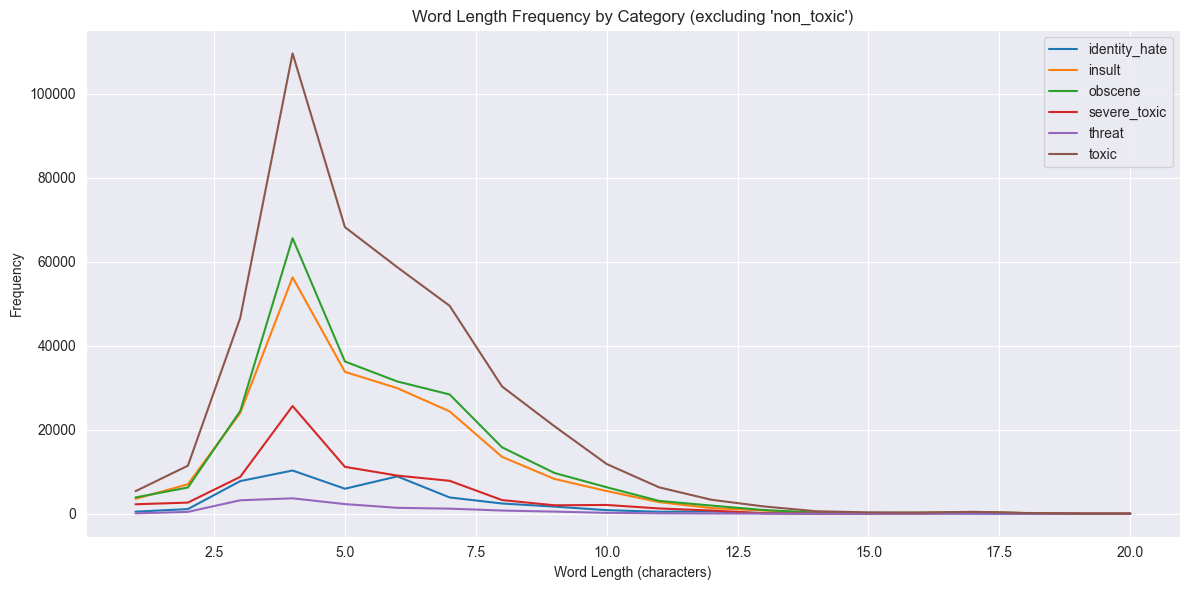

In [72]:
# Define the maximum word length to include
max_len = 20

# Create the plot
plt.figure(figsize=(12, 6))

# Loop through categories, skipping 'non_toxic'
for key, category in categories_norm.items():
    if key == 'non_toxic':
        continue

    fd_len = FreqDist(len(w) for w in category if len(w) <= max_len)
    lengths = list(range(1, max_len + 1))
    freqs = [fd_len[l] for l in lengths]
    plt.plot(lengths, freqs, label=key)

# Add labels and legend
plt.title("Word Length Frequency by Category (excluding 'non_toxic')")
plt.xlabel("Word Length (characters)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Most Common Words

In [21]:
corpus_fdist = nltk.FreqDist(corpus.words())
print(corpus_fdist.most_common(10))

corpus_norm_fdist = nltk.FreqDist(corpus_norm)
print(corpus_norm_fdist.most_common(10))

def percentage(count, total):
    return 100 * count / total

total_words = len(corpus.words())

for category in corpus.categories():
    words = corpus.words(categories=category)
    total = len(words)
    fdist = FreqDist(words)
    print(f"\nTop 5 words in {category}:")
    for word, freq in fdist.most_common(5):
        print(f"{word}: {freq} ({percentage(freq, total):.2f}%)")

for key, category in categories_norm.items():
    total = len(category)
    fdist = FreqDist(category)
    print(f"\nTop 5 words in {key} (normalized):")
    for word, freq in fdist.most_common(5):
        print(f"{word}: {freq} ({percentage(freq, total):.2f}%)")

[('.', 611200), (',', 485094), ('the', 464788), ('to', 305180), ('I', 247766), ('of', 230916), ('and', 226907), ('a', 226299), ("'", 218543), ('you', 213319)]
[('article', 58815), ('wikipedia', 52716), ('page', 48707), ('talk', 38419), ('fuck', 36153), ('like', 31597), ('one', 30619), ('please', 30559), ('would', 30303), ('see', 22430)]

Top 5 words in identity_hate:
.: 3180 (3.60%)
NIGGER: 2131 (2.41%)
,: 2111 (2.39%)
you: 1942 (2.20%)
a: 1694 (1.92%)

Top 5 words in insult:
.: 19582 (4.17%)
you: 13108 (2.79%)
,: 12829 (2.73%)
a: 9777 (2.08%)
I: 8480 (1.81%)

Top 5 words in non_toxic:
.: 516448 (4.27%)
the: 430018 (3.56%)
,: 423643 (3.50%)
to: 275818 (2.28%)
of: 209652 (1.73%)

Top 5 words in obscene:
.: 22441 (4.32%)
,: 14443 (2.78%)
you: 13178 (2.53%)
a: 9989 (1.92%)
I: 9872 (1.90%)

Top 5 words in severe_toxic:
YOU: 5493 (3.66%)
.: 5050 (3.37%)
!: 4580 (3.05%)
,: 3620 (2.41%)
you: 3540 (2.36%)

Top 5 words in threat:
I: 1966 (6.02%)
.: 1937 (5.93%)
,: 1096 (3.36%)
you: 1079 (3.30%)

Most common bigrams

In [70]:
# For the entire original corpus
corpus_bigrams = list(bigrams(corpus.words()))
corpus_bigram_fdist = FreqDist(corpus_bigrams)
print(corpus_bigram_fdist.most_common(10))

# For the entire normalized corpus
corpus_norm_bigrams = list(bigrams(corpus_norm))
corpus_norm_bigram_fdist = FreqDist(corpus_norm_bigrams)
print(corpus_norm_bigram_fdist.most_common(10))

# For each category in the original corpus
for category in corpus.categories():
    words = corpus.words(categories=category)
    bigrams_cat = list(bigrams(words))
    total = len(bigrams_cat)
    fdist = FreqDist(bigrams_cat)
    print(f"\nTop 5 bigrams in {category}:")
    for bigram, freq in fdist.most_common(5):
        print(f"{bigram}: {freq} ({percentage(freq, total):.2f}%)")

# For each category in the normalized corpus
for key, category_words in categories_norm.items():
    bigrams_cat = list(bigrams(category_words))
    total = len(bigrams_cat)
    fdist = FreqDist(bigrams_cat)
    print(f"\nTop 5 bigrams in {key} (normalized):")
    for bigram, freq in fdist.most_common(5):
        print(f"{bigram}: {freq} ({percentage(freq, total):.2f}%)")

[(("'", 's'), 70335), (('.', 'I'), 62622), (("'", 't'), 62238), (('of', 'the'), 50490), ((',', 'and'), 45570), (('I', "'"), 36524), (('in', 'the'), 36359), ((',', 'I'), 33530), ((',', 'but'), 28152), (('to', 'the'), 26733)]
[(('talk', 'page'), 14178), (('nigger', 'nigger'), 8765), (('fuck', 'fuck'), 7794), (('ass', 'ass'), 4737), (('speedy', 'deletion'), 4415), (('go', 'fuck'), 4392), (('jew', 'fat'), 4315), (('fat', 'jew'), 4287), (('die', 'die'), 3824), (('would', 'like'), 3725)]

Top 5 bigrams in identity_hate:
('NIGGER', 'NIGGER'): 1768 (2.00%)
('JEW', 'FAT'): 1234 (1.40%)
('FAT', 'JEW'): 1226 (1.39%)
('DIE', 'DIE'): 632 (0.71%)
('is', 'a'): 512 (0.58%)

Top 5 bigrams in insult:
("'", 't'): 2369 (0.50%)
('.', 'I'): 2122 (0.45%)
('FUCK', 'YOU'): 1856 (0.40%)
("'", 's'): 1757 (0.37%)
('NIGGER', 'NIGGER'): 1701 (0.36%)

Top 5 bigrams in non_toxic:
("'", 's'): 62115 (0.51%)
("'", 't'): 51149 (0.42%)
('.', 'I'): 50821 (0.42%)
('of', 'the'): 47828 (0.40%)
(',', 'and'): 41542 (0.34%)

Top

Most common words dispersion

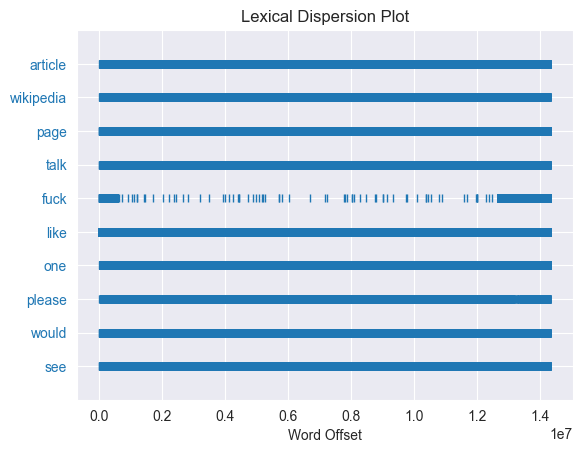

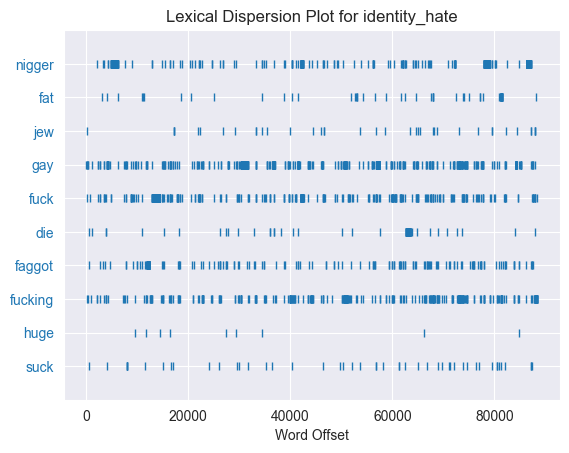

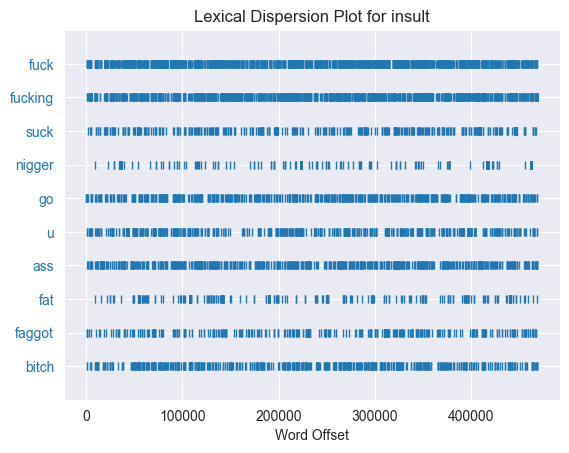

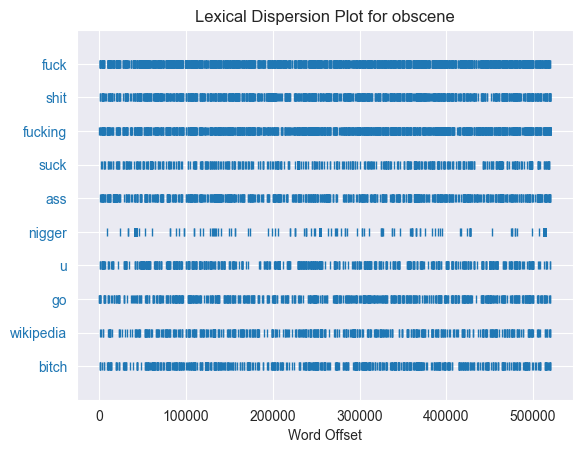

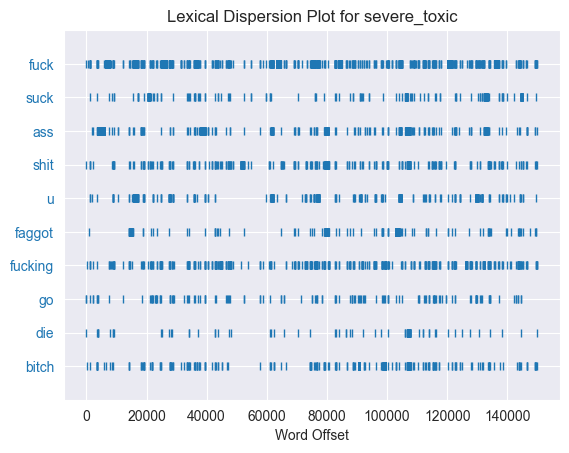

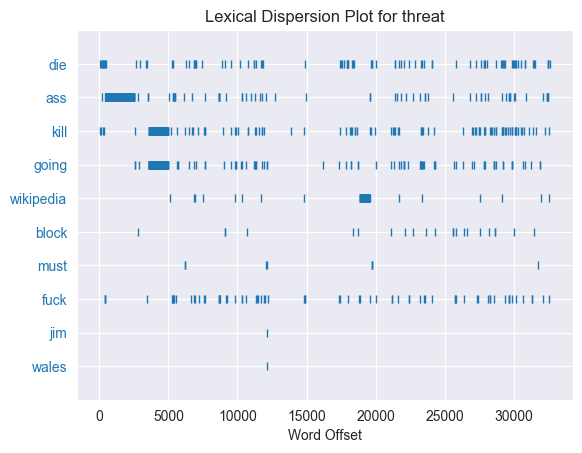

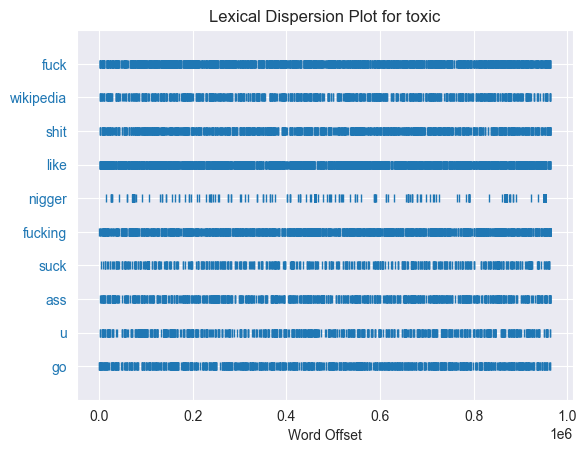

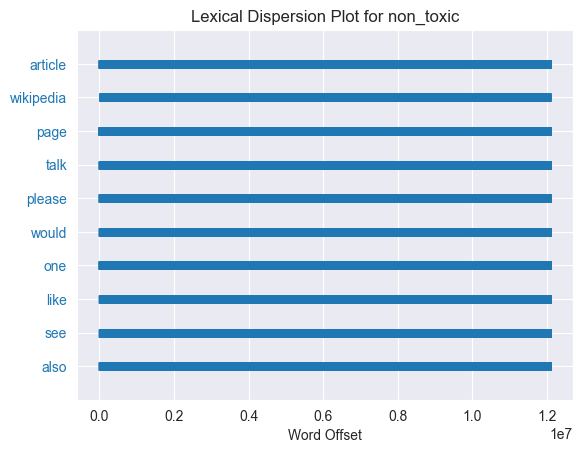

In [67]:
corpus_fdist = nltk.FreqDist(corpus_norm)

top_words = [word for word, freq in corpus_fdist.most_common(10)]

nltk.Text(corpus.words()).dispersion_plot(top_words)

for key, category in categories_norm.items():
    corpus_fdist = nltk.FreqDist(category)

    top_words = [word for word, freq in corpus_fdist.most_common(10)]

    ax = nltk.Text(corpus.words(categories=key)).dispersion_plot(top_words)
    plt.title(f"Lexical Dispersion Plot for {key}")
    plt.show()


In [81]:
cfd_upper = ConditionalFreqDist()

for category in corpus.categories():
    words = corpus.words(categories=category)
    total_letters = sum(1 for w in words for c in w if c.isalpha())
    uppercase_letters = sum(1 for w in words for c in w if c.isupper())
    if total_letters > 0:
        percentage_upper = (uppercase_letters / total_letters) * 100
        cfd_upper[category]['uppercase_percentage'] = percentage_upper

# Mostrar el porcentaje de mayúsculas por categoría
for category in corpus.categories():
    print(f"{category}: {cfd_upper[category]['uppercase_percentage']:.2f}%")

identity_hate: 30.02%
insult: 23.26%
non_toxic: 4.54%
obscene: 23.00%
severe_toxic: 45.25%
threat: 34.38%
toxic: 19.61%


In [84]:
cfd_punct = ConditionalFreqDist()

for category in corpus.categories():
    text = ' '.join(corpus.words(categories=category))
    total_chars = len(text)
    excls = text.count('!')
    ques = text.count('?')
    if total_chars:
        cfd_punct[category]['excl_pct'] = excls / total_chars * 100
        cfd_punct[category]['ques_pct'] = ques / total_chars * 100

for cat in corpus.categories():
    print(
        f"{cat}: ! → {cfd_punct[cat]['excl_pct']:.2f}%, "
        f"? → {cfd_punct[cat]['ques_pct']:.2f}%, "
    )

identity_hate: ! → 0.73%, ? → 0.14%, 
insult: ! → 1.30%, ? → 0.17%, 
non_toxic: ! → 0.08%, ? → 0.10%, 
obscene: ! → 1.12%, ? → 0.16%, 
severe_toxic: ! → 3.47%, ? → 0.08%, 
threat: ! → 5.27%, ? → 0.10%, 
toxic: ! → 1.19%, ? → 0.19%, 


In [85]:
cfd_reps = ConditionalFreqDist()

for category in corpus.categories():
    words = corpus.words(categories=category)
    text = ' '.join(words)
    total_chars = len(text)
    total_words = len(words) or 1

    char_reps = len(re.findall(r'(.)\1{2,}', text))
    word_reps = len(re.findall(r'\b(\w+)( \1\b)+', text.lower()))

    cfd_reps[category]['char_reps_pct'] = char_reps / total_chars * 100
    cfd_reps[category]['word_reps_pct'] = word_reps / total_words * 100

for cat in corpus.categories():
    print(
        f"{cat}: char repeats → {cfd_reps[cat]['char_reps_pct']:.2f}%, "
        f"word repeats → {cfd_reps[cat]['word_reps_pct']:.2f}%"
    )

identity_hate: char repeats → 0.19%, word repeats → 0.21%
insult: char repeats → 0.26%, word repeats → 0.13%
non_toxic: char repeats → 0.07%, word repeats → 0.04%
obscene: char repeats → 0.28%, word repeats → 0.19%
severe_toxic: char repeats → 0.55%, word repeats → 0.19%
threat: char repeats → 0.25%, word repeats → 0.36%
toxic: char repeats → 0.23%, word repeats → 0.21%


5. Tagging corpus and analysis

In [91]:
# Tokenization and POS tagging
total_sents = []
tagged_sents = []
file_to_sent_count = {}

for fid in corpus.fileids():
    sent_count = 0
    for line in corpus.raw(fid).splitlines():
        if line.strip():
            tokens = word_tokenize(line)
            total_sents.append(tokens)
            tagged_sents.append(nltk.pos_tag(tokens))
            sent_count += 1
    file_to_sent_count[fid] = sent_count

Total sentences: 464794

Sample tagged sentences:
[('You', 'PRP'), ('are', 'VBP'), ('gay', 'JJ'), ('or', 'CC'), ('antisemmitian', 'JJ'), ('?', '.')]
[('Archangel', 'NNP'), ('WHite', 'NNP'), ('Tiger', 'NNP')]
[('Meow', 'NN'), ('!', '.'), ('Greetingshhh', 'NN'), ('!', '.')]
[('Uh', 'NNP'), (',', ','), ('there', 'EX'), ('are', 'VBP'), ('two', 'CD'), ('ways', 'NNS'), (',', ','), ('why', 'WRB'), ('you', 'PRP'), ('do', 'VBP'), ('erased', 'VBN'), ('my', 'PRP$'), ('comment', 'NN'), ('about', 'IN'), ('WW2', 'NNP'), (',', ','), ('that', 'IN'), ('holocaust', 'NN'), ('was', 'VBD'), ('brutally', 'RB'), ('slaying', 'VBG'), ('of', 'IN'), ('Jews', 'NNP'), ('and', 'CC'), ('not', 'RB'), ('gays/Gypsys/Slavs/anyone', 'NN'), ('...', ':')]
[('1', 'CD'), ('-', ':'), ('If', 'IN'), ('you', 'PRP'), ('are', 'VBP'), ('anti-semitian', 'JJ'), (',', ','), ('than', 'IN'), ('shave', 'VB'), ('your', 'PRP$'), ('head', 'NN'), ('bald', 'NN'), ('and', 'CC'), ('go', 'VB'), ('to', 'TO'), ('the', 'DT'), ('skinhead', 'JJ'), ('

In [ ]:
# Save tagged corpus in subfolders by category
output_dir = 'tagged_corpus'
os.makedirs(output_dir, exist_ok=True)

offset = 0
for category in corpus.categories():
    category_dir = os.path.join(output_dir, category)
    os.makedirs(category_dir, exist_ok=True)

    # Get all files for the current category
    fileids = corpus.fileids(categories=[category])
    all_comments = []

    for fid in fileids:
        comments = [c for c in corpus.raw(fid).splitlines() if c.strip()]
        all_comments.extend(comments)

    # Save combined tagged output for this category
    output_file = os.path.join(category_dir, f"{category}_tagged.txt")
    with open(output_file, 'w', encoding='utf-8') as f:
        for sent in tagged_sents[offset:offset + len(all_comments)]:
            f.write(' '.join(f"{w}/{t}" for w, t in sent) + '\n')
    offset += len(all_comments)

In [92]:
# Load corpus
tagged_corpus = CategorizedPlaintextCorpusReader(
    output_dir,
    r'.*\.txt',
    cat_pattern=r"([^/.]+)/.*"
)

Analysis

In [103]:

negative_adjectives = {"bad", "satanistic", "antisemmitian", "racist", "evil", "nasty", "ugly", "fat", "nazi"}
mode_adverb_check = lambda w: w.endswith("ly")


pos_summary = defaultdict(Counter)
specific_summary = defaultdict(Counter)


for category in tagged_corpus.categories():
    for fileid in tagged_corpus.fileids(categories=[category]):

        words_tags = [tuple(token.rsplit("/", 1)) for token in tagged_corpus.raw(fileid).split()]

        for word, tag in words_tags:
            word_lower = word.lower()

            if tag.startswith("NN"):
                pos_summary[category]["Noun"] += 1
            elif tag.startswith("VB"):
                pos_summary[category]["Verb"] += 1
                if tag == "VB":
                    specific_summary[category]["Imperative Verbs"] += 1
            elif tag.startswith("JJ"):
                pos_summary[category]["Adjective"] += 1
                if word_lower in negative_adjectives:
                    specific_summary[category]["Negative Adjectives"] += 1
            elif tag.startswith("RB"):
                pos_summary[category]["Adverb"] += 1
                if mode_adverb_check(word_lower):
                    specific_summary[category]["Manner Adverbs"] += 1
            elif tag in {"PRP", "PRP$", "WP", "WP$"}:
                pos_summary[category]["Pronoun"] += 1

df_pos = pd.DataFrame(pos_summary).T.fillna(0)
df_pos_percent = df_pos.div(df_pos.sum(axis=1), axis=0) * 100


relevant_totals = df_pos["Verb"] + df_pos["Adjective"] + df_pos["Adverb"]
df_specific = pd.DataFrame(specific_summary).T.fillna(0)
df_specific_percent = df_specific.div(relevant_totals, axis=0) * 100


print("POS distribution (%) by category:")
display(df_pos_percent.round(2))

print("\nSpecific features (% of related POS) by category:")
display(df_specific_percent.round(2))

POS distribution (%) by category:


,Pronoun,Verb,Adjective,Noun,Adverb
identity_hate,11.80,19.89,10.57,53.05,4.69
insult,14.72,22.49,8.88,48.44,5.48
non_toxic,12.68,27.67,10.30,40.46,8.88
obscene,14.43,22.39,8.52,49.07,5.60
severe_toxic,11.51,15.58,7.53,63.29,2.09
threat,19.97,25.55,5.01,45.73,3.74
toxic,14.62,23.26,8.78,47.06,6.28



Specific features (% of related POS) by category:


,Negative Adjectives,Manner Adverbs,Imperative Verbs
identity_hate,0.59,2.01,13.75
insult,0.47,2.56,15.03
non_toxic,0.11,4.25,16.50
obscene,0.44,2.55,15.42
severe_toxic,0.68,1.01,12.15
threat,0.33,1.72,25.33
toxic,0.46,2.99,15.49
